In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
import geopandas as gp
import os

import haversine as hs
from watertap3.truck_pipe_cost_functions import elevation
from IPython.display import clear_output

Create a csv with centroids based on k means clustering

In [2]:
# Read brackish water previous lcow file with locations
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis.csv')

In [12]:
len(bw_cluster_kmeans)

5114

In [3]:
# Function to form clusters

os.environ["OMP_NUM_THREADS"] = '1'

def form_cluster(df,n_clusters = 3):
    kmeans = KMeans(n_clusters = n_clusters, init ='k-means++')
    kmeans.fit(df[df.columns[1:3]])  # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(df[df.columns[1:3]])
    centers = kmeans.cluster_centers_  # Coordinates of cluster centers.
    labels = kmeans.predict(df[df.columns[1:3]])  # Labels of each point
    centers_array = []
    for idx,row in df.iterrows():
        centers_array.append(centers[int(row['cluster_label'])])
    df['centers'] = centers_array
    
    return df

In [35]:
bw_df[bw_df['state_alpha']=='IN']

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,lcow,pipe_cost,recovery,capital,onm,elec_int,tds_out
80,FETH-404430N0845630.1,IN,Adams,40.741667,-84.941694,206.0,0.012706,1.91,Indiana,0.0736,1.340928,0.209841,91.633281,5.207714,0.153568,2.444237,0.103874


In [13]:
bw_cluster_kmeans = pd.DataFrame()

# Iterate through each state

for state in ['AZ']:#bw_df['state_alpha'].unique():
    # print(state)
    # kmeans doesn't work for fewer than 3 points. Calculate centroid for these cases
    if len(bw_df[bw_df['state_alpha'] == state])<=3:
        continue

    bw_state_df = bw_df[bw_df['state_alpha'] == state]

    # First pass at clustering for a state
    bw_state_df_loc = bw_state_df[['unique_site_ID','Latitude','Longitude']].copy()
    bw_state_df_loc = form_cluster(bw_state_df_loc)

    # Assign well yield
    bw_state_df_loc['well_yield'] = bw_df['well_yield']
    
    # To keep track of clusters and new created clusters if the maximum capacity of a treatment plant is exceeded
    prev_max_cluster_label = 0

    # Dataframe for each state with their respective cluster id
    cluster_state_df = pd.DataFrame()

    for cluster_id in bw_state_df_loc['cluster_label'].unique():
        
        # Check if maximum capacity of treatment plant is exceeded
        well_yield_total = sum(bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id]['well_yield'])
        
        if well_yield_total > 10: #--> Update the number based on Kay Bailey
            # If exceed increase number of clusters in the original cluster and redo
            # print(cluster_id,well_yield_total)
            # print('Number of clusters to not hit maximum capacity:', round(well_yield_total/5))
            
            cluster_sub_df = bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id].copy()
            temp_df = form_cluster(cluster_sub_df,n_clusters = round(well_yield_total/5))
            temp_df['cluster_label'] = prev_max_cluster_label + temp_df['cluster_label']
            prev_max_cluster_label = max(temp_df['cluster_label'])
            
            cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
        else:
            # If maximum capacity is not exceeded add to state data frame
            cluster_state_df = pd.concat([cluster_state_df,bw_state_df_loc[bw_state_df_loc['cluster_label']==cluster_id]],ignore_index=True)

    bw_cluster_kmeans = pd.concat([bw_cluster_kmeans,cluster_state_df])
    

In [18]:
# # bw_df_tx_lo['well_yield'] = bw_df['well_yield']
# prev_max_cluster_label = 0

# cluster_state_df = pd.DataFrame()

# for cluster_id in bw_df_tx_loc['cluster_label'].unique():
#     well_yield_total = sum(bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id]['well_yield'])
#     if well_yield_total > 10:
#         print(cluster_id,well_yield_total)
#         print('Number of clusters to not hit maximum capacity:', round(well_yield_total/5))
#         cluster_sub_df = bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id].copy()
#         temp_df = form_cluster(cluster_sub_df,n_clusters = round(well_yield_total/5))
#         temp_df['cluster_label'] = prev_max_cluster_label + temp_df['cluster_label']
#         prev_max_cluster_label = max(temp_df['cluster_label'])
        
#         cluster_state_df = pd.concat([cluster_state_df,temp_df],ignore_index=True)
#     else:
#         cluster_state_df = pd.concat([cluster_state_df,bw_df_tx_loc[bw_df_tx_loc['cluster_label']==cluster_id]],ignore_index=True)

# cluster_state_df.head()
        

,unique_site_ID,Latitude,Longitude,cluster_label,centers,well_yield
0,FETH-261730N0974730.1,26.291667,-97.791694,2,"[28.981470325, -98.658625415]",0.056956
1,FETH-262920N0974650.1,26.488889,-97.780583,2,"[28.981470325, -98.658625415]",0.063528
2,FETH-291610N1003320.1,29.269444,-100.555583,2,"[28.981470325, -98.658625415]",0.043813
3,NURE-OR10554,29.192000,-98.481000,2,"[28.981470325, -98.658625415]",0.030283
4,NURE-OR10556,29.243000,-98.431000,2,"[28.981470325, -98.658625415]",0.031545


In [16]:
us_counties = gp.read_file(r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\GeoData\US_County_Boundaries\US_CountyBndrys.shp')
us_counties = us_counties.to_crs("EPSG:4326")

state_code = '04'
state = us_counties.loc[us_counties['STATEFP']==state_code]

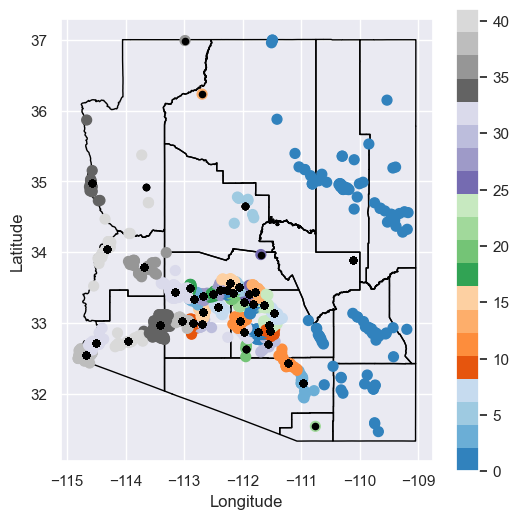

In [20]:
centers_log = []
centers_lat = []
for idx , row in bw_cluster_kmeans.iterrows():
    centers_log.append(row['centers'][1])
    centers_lat.append(row['centers'][0])

fig, ax = plt.subplots(figsize = (6,6))

state.plot(ax=ax,facecolor ='none',edgecolor ='black')
bw_cluster_kmeans.plot.scatter(ax=ax, x = 'Longitude', y = 'Latitude', c=bw_cluster_kmeans['cluster_label'].values, s=50, cmap='tab20c')
ax.scatter(centers_log, centers_lat, c='black', s=20)
plt.show()


Create dataframe with all BW site data

In [23]:
bw_cluster_kmeans.head(5)

,unique_site_ID,Latitude,Longitude,cluster_label,centers,well_yield
0,AZ_GEOTH-AZ0183,32.639722,-111.945833,19,"[32.63337962, -111.94377176]",0.031545
1,AZ_GEOTH-AZ0274,32.850556,-111.584444,10,"[32.888495339130436, -111.52902446739131]",0.070667
2,AZ_GEOTH-AZ0297,32.894444,-111.558611,10,"[32.888495339130436, -111.52902446739131]",0.125000
3,AZ_GEOTH-AZ0327,32.931111,-111.550000,24,"[32.976178106896555, -111.54890688965517]",0.037854
4,AZ_GEOTH-AZ0338,32.936944,-111.566944,24,"[32.976178106896555, -111.54890688965517]",0.063000


In [30]:
centers_log = []
centers_lat = []
for idx , row in bw_cluster_kmeans.iterrows():
    centers_log.append(row['centers'][1])
    centers_lat.append(row['centers'][0])

bw_df_centroid = bw_df[bw_df['state_alpha']=='AZ'].copy()
bw_df_centroid['centroid_long']=centers_log
bw_df_centroid['centroid_lat']=centers_lat
bw_df_centroid['cluster_id']=bw_cluster_kmeans['cluster_label']

dist= []
centroid_elev = []
well_elev = []

for i in bw_df_centroid.index:
    clear_output(wait=True)
    print(i, i/len(bw_df_centroid.index))
    bw_long = bw_df_centroid.loc[i]['Longitude']
    bw_lat = bw_df_centroid.loc[i]['Latitude']

    bw_loc = (bw_lat,bw_long)

    cent_long = bw_df_centroid.loc[i]['centroid_long']
    cent_lat = bw_df_centroid.loc[i]['centroid_lat']

    cent_loc = (cent_lat,cent_long)

    dist_km = hs.haversine(cent_loc,bw_loc)

    dist.append(dist_km)
    centroid_elev.append(elevation(cent_lat,cent_long))
    well_elev.append(elevation(bw_lat,bw_long))


bw_df_centroid.head(5)

3244 1.9026392961876832


,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,lcow,pipe_cost,recovery,capital,onm,elec_int,tds_out,centroid_long,centroid_lat,cluster_id
0,AZ_GEOTH-AZ0183,AZ,Pinal,32.639722,-111.945833,682.0,0.031545,0.754442,Arizona,0.0628,0.966084,0.085111,92.866138,8.879727,0.314866,2.663241,0.056599,-111.943772,32.633380,19.0
1,AZ_GEOTH-AZ0274,AZ,Pinal,32.850556,-111.584444,374.0,0.070667,2.841712,Arizona,0.0628,0.862845,0.054834,89.781082,16.424565,0.657947,2.740707,0.100763,-111.529024,32.888495,10.0
2,AZ_GEOTH-AZ0297,AZ,Pinal,32.894444,-111.558611,3265.0,0.125000,2.888000,Arizona,0.0628,0.993614,0.038441,89.849854,25.566372,1.856132,6.058783,0.103629,-111.529024,32.888495,10.0
3,AZ_GEOTH-AZ0327,AZ,Pinal,32.931111,-111.550000,2566.0,0.037854,9.120000,Arizona,0.0628,1.305189,0.091942,86.213229,11.191279,0.615273,6.376542,0.210457,-111.548907,32.976178,24.0
4,AZ_GEOTH-AZ0338,AZ,Pinal,32.936944,-111.566944,3000.0,0.063000,1.901000,Arizona,0.0628,1.037091,0.056027,91.183172,14.827503,0.914241,5.555922,0.088042,-111.548907,32.976178,24.0


In [31]:
bw_df_centroid['dist_miles'] = dist
bw_df_centroid['centroid_elev'] = centroid_elev
bw_df_centroid['well_elev'] = well_elev

bw_df_centroid.head(5)

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,...,capital,onm,elec_int,tds_out,centroid_long,centroid_lat,cluster_id,dist_miles,centroid_elev,well_elev
0,AZ_GEOTH-AZ0183,AZ,Pinal,32.639722,-111.945833,682.0,0.031545,0.754442,Arizona,0.0628,...,8.879727,0.314866,2.663241,0.056599,-111.943772,32.633380,19.0,0.731205,462.139221,462.576752
1,AZ_GEOTH-AZ0274,AZ,Pinal,32.850556,-111.584444,374.0,0.070667,2.841712,Arizona,0.0628,...,16.424565,0.657947,2.740707,0.100763,-111.529024,32.888495,10.0,6.677364,444.350067,449.939636
2,AZ_GEOTH-AZ0297,AZ,Pinal,32.894444,-111.558611,3265.0,0.125000,2.888000,Arizona,0.0628,...,25.566372,1.856132,6.058783,0.103629,-111.529024,32.888495,10.0,2.840619,444.350067,441.981445
3,AZ_GEOTH-AZ0327,AZ,Pinal,32.931111,-111.550000,2566.0,0.037854,9.120000,Arizona,0.0628,...,11.191279,0.615273,6.376542,0.210457,-111.548907,32.976178,24.0,5.012267,427.284973,434.284180
4,AZ_GEOTH-AZ0338,AZ,Pinal,32.936944,-111.566944,3000.0,0.063000,1.901000,Arizona,0.0628,...,14.827503,0.914241,5.555922,0.088042,-111.548907,32.976178,24.0,4.675950,427.284973,432.622864


In [33]:
path = r'\Users\mhardika\Documents\AMO\GeoToolAll_Methods\Water Source Data\Brackish'
bw_df_centroid.to_csv(path+r'\az_bw_lcow_kmeans.csv')

Calculate distance between centroid and wells